In [1]:
import shap
import numpy as np
from src.modules.loader.data_loader import DataLoader
from src.modules.llm.llm_client import LLMClient
from src.modules.rag.rag_engine import RAGEngine
from src.modules.rag.multihop_rag_engine import MultiHopRAGEngine
from src.modules.explainers.shap_explainer import ShapExplainer

/home/nilspoethkow/Code/Uni/XAI/xai-rag/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Shap

## Evaluation Techniques

**NOTE**: We are using the FullWiki version of the HotPotQA Dataset. Meaning the **entire Wiki** is the context for each question.

There are no ground truth explanations available for any neural model. We therefore have to use different evaluation metrics.

1. In the Paper "A study on the Interpretability of Neural Retrieval Models using
DeepSHAP" a LIME based explanation was used as proxy (https://github.com/marcotcr/lime)
2. **Faithfullness/Fidelity** We can also use a perturbation based evaluation approach. Meaning we will leave out the as important identified tokens in the query and rerun the retrieval comparing the ranking to each other (AOPC = "Area over perturbation curve"). (https://github.com/CristianCosci/AOPC_MoRF)
3. **Sparseness** Leave out all tokens except the top k identified by DeepSHAP.

${AOPC}_M = \frac{1}{L+1} \left\langle \sum_{k=1}^{L} f(x^{(0)}_M) - f(x^{(k)}_M) \right\rangle_{p(X)}$

### Experiment Setup

Bound by the Computational cost of DeepShap! (Run on KIGS Server?)
1. Select a finite amount of instances from the HotpotQA Dataset.
2. Conduct the Retrieval on those instances.
3. Compute Metrics for every Instance and average them to get overall score for DeepShap Explanability.

It is crucial to select the fitting Background image for DeepSHAP. Fortunatly this research was already conducted by [Fernando et. al.](https://arxiv.org/abs/1907.06484). The selection is dependent on the NRM used for the retrieval, tho performances are fairly similar for each NRM.

![Performance Metrics Background Images](img/image.png)

**ATTENTION**: We currently use "sentence-transformers/all-MiniLM-L6-v2" as the embedding model. This is a simple Bi-Encoder and no NRM. A NRM is a Reranker, using both query and document together to generate a relevance score instead of an embedding vector. These models yield significantly better matching results for query and documents, but to the drawback of computational cost and time.

## Next Steps

Discuss for general Experimental setup.

1. Explaining the output of the LLM based on the retrieved documents.
2. Explaining the retrieved documents.

This leads to key questions.

1. Should we compare those two experiments or link them in some way (**A sort of Pipeline for Explaining Retrieval (so both sides: Retrieval and LLM)**)
- If so how?
2. Should the setups for the experiments differ? 
- Using a NRM Reranking for DeepShap and no NRM for other project part?

# Implementation

First test implementation of DeepShap.

**NOTES:**
- We are looking at only the top document and calculate the AOPC-Metric for only that document. Since it was ranked the highest by the Retriever (no matter if it's a NRM or just Similarity Measure) we can assume that the identified Tokens are relevant for the Query.#
- We can also use LIME for Explanation or Comparison for DeepShap, the implementation is straight forward in fairly similar

### 1. Shap for Bi-Encoder using shap.KernelExplainer (Cosine Similarity)

The **KernelExplainer** is similar to LIME, cause it explains a local instance using the set of locally pertubated instances and fits a linear model on the set. It differs by the way it approximates the values if that model, it uses the approximation of shapely-values, whereas LIME uses a simple exponential kernel.

We use the top Document for the AOPC Metric.

Setup RAG-Engine with LLM-Client.

In [2]:
dataLoader = DataLoader()
documents = dataLoader.setup()

ragEngine = RAGEngine()
ragEngine.setup(documents=documents, k=50)

client = LLMClient(provider="ollama", model_name="gemma3:4b")
mh_rag = MultiHopRAGEngine(rag_engine=ragEngine, llm_client=client, num_hops=2)

✓ Dataset found at /home/nilspoethkow/Code/Uni/XAI/xai-rag/src/data/raw/hotpot_test_fullwiki_v1.json
Loading data into memory...
✓ Loaded 7405 questions.
Converting HotPotQA contexts to documents...


Processing Articles: 100%|██████████| 7405/7405 [00:00<00:00, 9288.94it/s] 


✓ Created 73774 context chunks.
Loading existing vector store from ../data/vector_db...
RagEngine ready.
Connecting to local Ollama (gemma3:4b)...


Setup and run Multi-Hop Retrieval experiment. For this we will select a random set of questions from the dataset().

In [3]:
# select question randomly (with seed)
N = 1
rng = np.random.default_rng(seed=180)

selected_documents = rng.choice(documents, N)

# storing all traces
traces = []

for doc in selected_documents:
    question = doc.metadata.get("question")

    trace, all_documents = mh_rag.run_and_trace(question)

    traces.append(trace)

--- Starting Multi-Hop Search for: 'What was the political party of the person whose resignation resulted in the appointment of Ferrell Haille to the Tennessee Senate?   ' ---

[ Hop 1 ]
Executing search with query: 'What was the political party of the person whose resignation resulted in the appointment of Ferrell Haille to the Tennessee Senate?   '
Generating next query...

[ Hop 2 ]
Executing search with query: '"John Adams political party"'

Generating final answer...

--- Multi-Hop Search Complete. Final Answer: The person whose resignation resulted in the appointment of Ferrell Haille to the Tennessee Senate was John Adams, who was a member of the Federalist Party. ---
--- Multi-Hop Context: 

 ('<doc id="chunk-1-1" from_hop="1" search_query="What was the political party of the person whose resignation resulted in the appointment of Ferrell Haille to the Tennessee Senate?   ">\n[Document(id=\'6c7e15db-7ecb-49bb-820d-edbab02f1287\', metadata={\'split\': \'train\', \'answer\': True

Setup Explainer and explain retrievals for every hop. What else could be explained here?

In [4]:
explainer = ShapExplainer(rag_engine=ragEngine)
explanations = []

for trace in traces: 

    explanation = {"explanation_hops": explainer.explain(trace, explained_doc_key="retrieved_document_for_this_hop"), 
                   "initial_query": trace["initial_query"],
                   "final_answer": trace["final_answer"]}
    
    explanations.append(explanation)

--- Explaining Hop 1 (retrieved_document_for_this_hop) ---


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


--- Explaining Hop 2 (retrieved_document_for_this_hop) ---


100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


What was the political party of the person whose resignation resulted in the appointment of Ferrell Haille to the Tennessee Senate?   


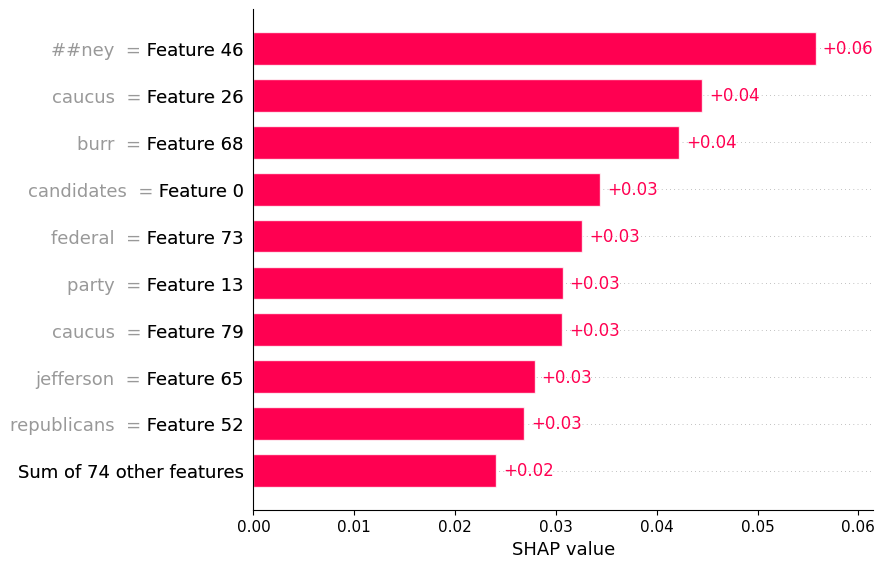

In [6]:
initial_query = explanations[0]["initial_query"]

hop1 = explanations[0]["explanation_hops"]["hop_1"]
display_tokens = [t + " " for t in hop1['tokens']]

shap_object = shap.Explanation(
         values=np.array(hop1['shap_values']),
         base_values=0.0,
         data=np.array(display_tokens)
     )

print(initial_query)
# shap.plots.waterfall(shap_object, max_display=10)
shap.plots.bar(shap_object)

### 2. LIME Explainer

Molnar, LIME for text data.

In [6]:
import lime
from src.modules.lime_explainer import LimeExplainer

In [7]:
lime_explainer = LimeExplainer(rag_engine=ragEngine)

lime_explanations = lime_explainer.explain(trace, explained_doc_key="retrieved_document_for_this_hop")

--- LIME Explaining Hop 1 (retrieved_document_for_this_hop) ---
--- LIME Explaining Hop 2 (retrieved_document_for_this_hop) ---


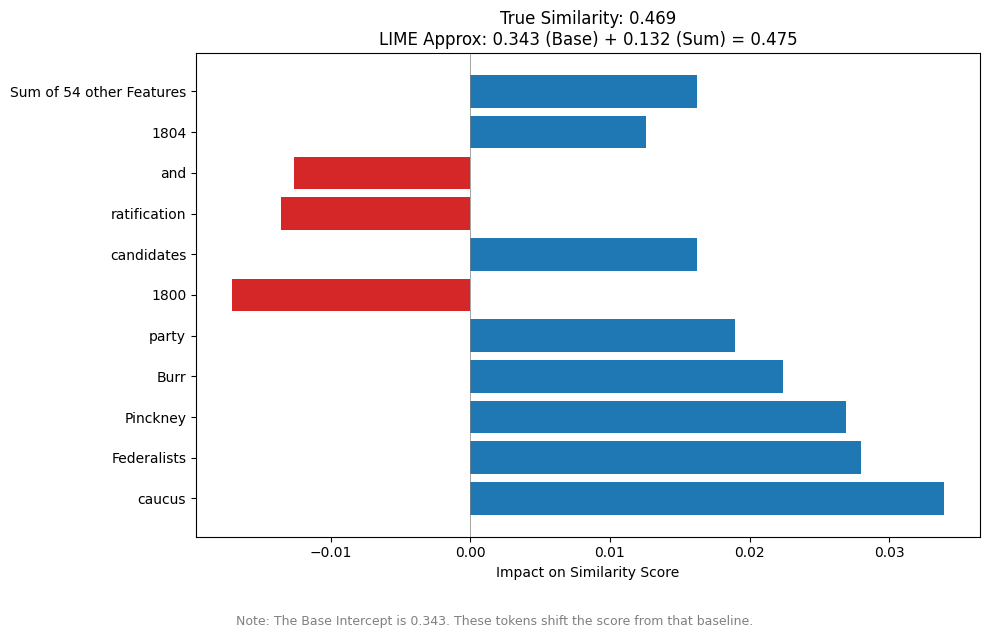

In [8]:
# Pass the WHOLE dictionary for the hop, not just ["explanation_tuples"]
lime_explainer.plot_bar(explanation_data=lime_explanations["hop_1"])

## Additions

It would be usefull to have the actual entire document text still available because the tokenizer "destroys" some of the words, s.t. the joined tokens don't make up a meaningfull text.